# Exploration of SHS27K Data

In [65]:
# Set-Up 
import pandas as pd
import torch
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import networkx as nx
import numpy as np
import seaborn as sns
import os

## HIGH-PPI Dataset Description

The `SHS27k` dataset contains human protein-protein interaction data from the STRING database. The main interaction file `protein.actions.SHS27k.STRING.pro2.txt` contains 54,812 protein pairs across 7 interaction types (binding, reaction, ptmod, activation, inhibition, catalysis, expression). The `protein.SHS27k.sequences.dictionary.pro3.tsv` file maps 1,552 protein identifiers to their amino acid sequences. 

The network structure is stored in `edge_list_12.npy`, which contains the binary adjacency matrix indicating which proteins interact with each other (top view of the hierarchical model). The `x_list.pt` PyTorch tensor stores the learned protein representations from the bottom view, serving as initial node features for the PPI network. 

Finally, `vec5_CTC.txt` contains residue-level physicochemical features for each amino acid, including 7 properties: isoelectric point, polarity, acidity/alkalinity, hydrogen bond acceptor/donor status, octanol-water partition coefficient, and topological polar surface area. 

Together, these files enable HIGH-PPI's hierarchical graph learning approach, where the bottom view models proteins as graphs of residues, and the top view models the PPI network where proteins themselves are nodes.

In [72]:
# Set the main path
main_path = '/Users/posmikdc/Documents/brown/classes/year2/fall25/csci2952g-dlgenomics/csci2952g-paper'
data_path = os.path.join(main_path, 'data/gao_shs27k_data')

# Define data and file objects
data = {}
files = [
    'protein.actions.SHS27k.STRING.pro2.txt',
    'protein.SHS27k.sequences.dictionary.pro3.tsv',
    'edge_list_12.npy',
    'x_list.pt',
    'vec5_CTC.txt'
]

# Read in files based on extension
for file in files:
    file_path = os.path.join(data_path, file)
    key = os.path.splitext(file)[0]
    
    if file.endswith('.npy'):
        data[key] = np.load(file_path, allow_pickle=True)
    elif file.endswith('.pt'):
        data[key] = torch.load(file_path, weights_only=False)
    elif file.endswith('.tsv'):
        data[key] = pd.read_csv(file_path, sep='\t')
    else:
        data[key] = pd.read_csv(file_path, sep=r'\s+')

## Visualize PPI Network by the STRING Binding Score

There are different types of PPI interactions. The first histogram shows us a count of interaction types. `reaction` is the most common (n = 15,626) and `expression` is least common (n = 1,448). 

/var/folders/hw/h_ytc0w90js5pz0zw2dz9p440000gn/T/ipykernel_4418/4134024687.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=mode_counts.index, y=mode_counts.values, palette='viridis')


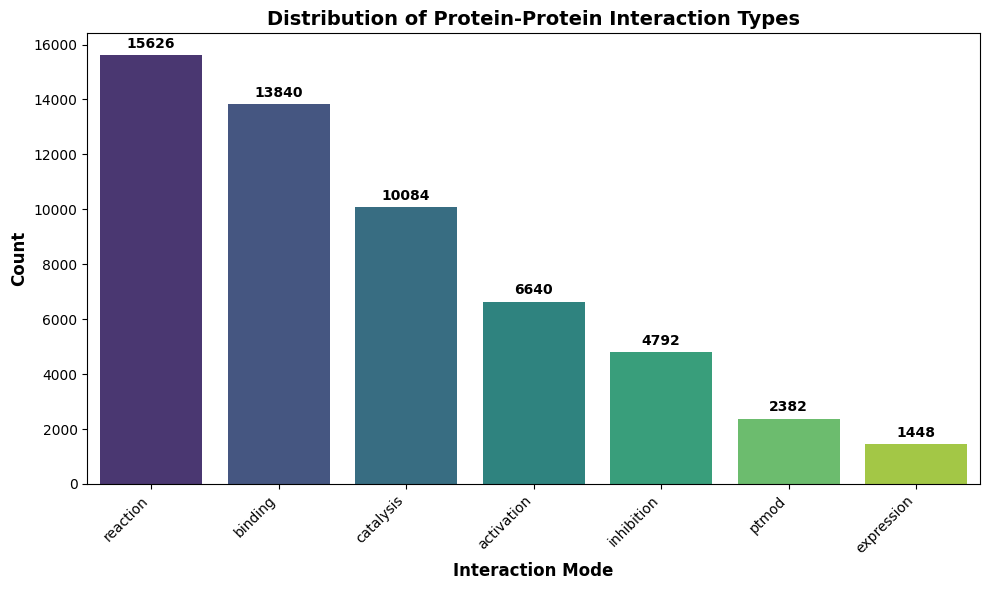

In [60]:
# Count interactions by mode
mode_counts = ppi_df['mode'].value_counts().sort_values(ascending=False)

# Create histogram
plt.figure(figsize=(10, 6))
sns.barplot(x=mode_counts.index, y=mode_counts.values, palette='viridis')

plt.xlabel('Interaction Mode', fontsize=12, fontweight='bold')
plt.ylabel('Count', fontsize=12, fontweight='bold')
plt.title('Distribution of Protein-Protein Interaction Types', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')

# Add value labels on top of bars
for i, v in enumerate(mode_counts.values):
    plt.text(i, v + max(mode_counts.values) * 0.01, str(v), 
             ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

Found 1662 interactions with score 900-999
Network has 380 nodes and 1662 edges


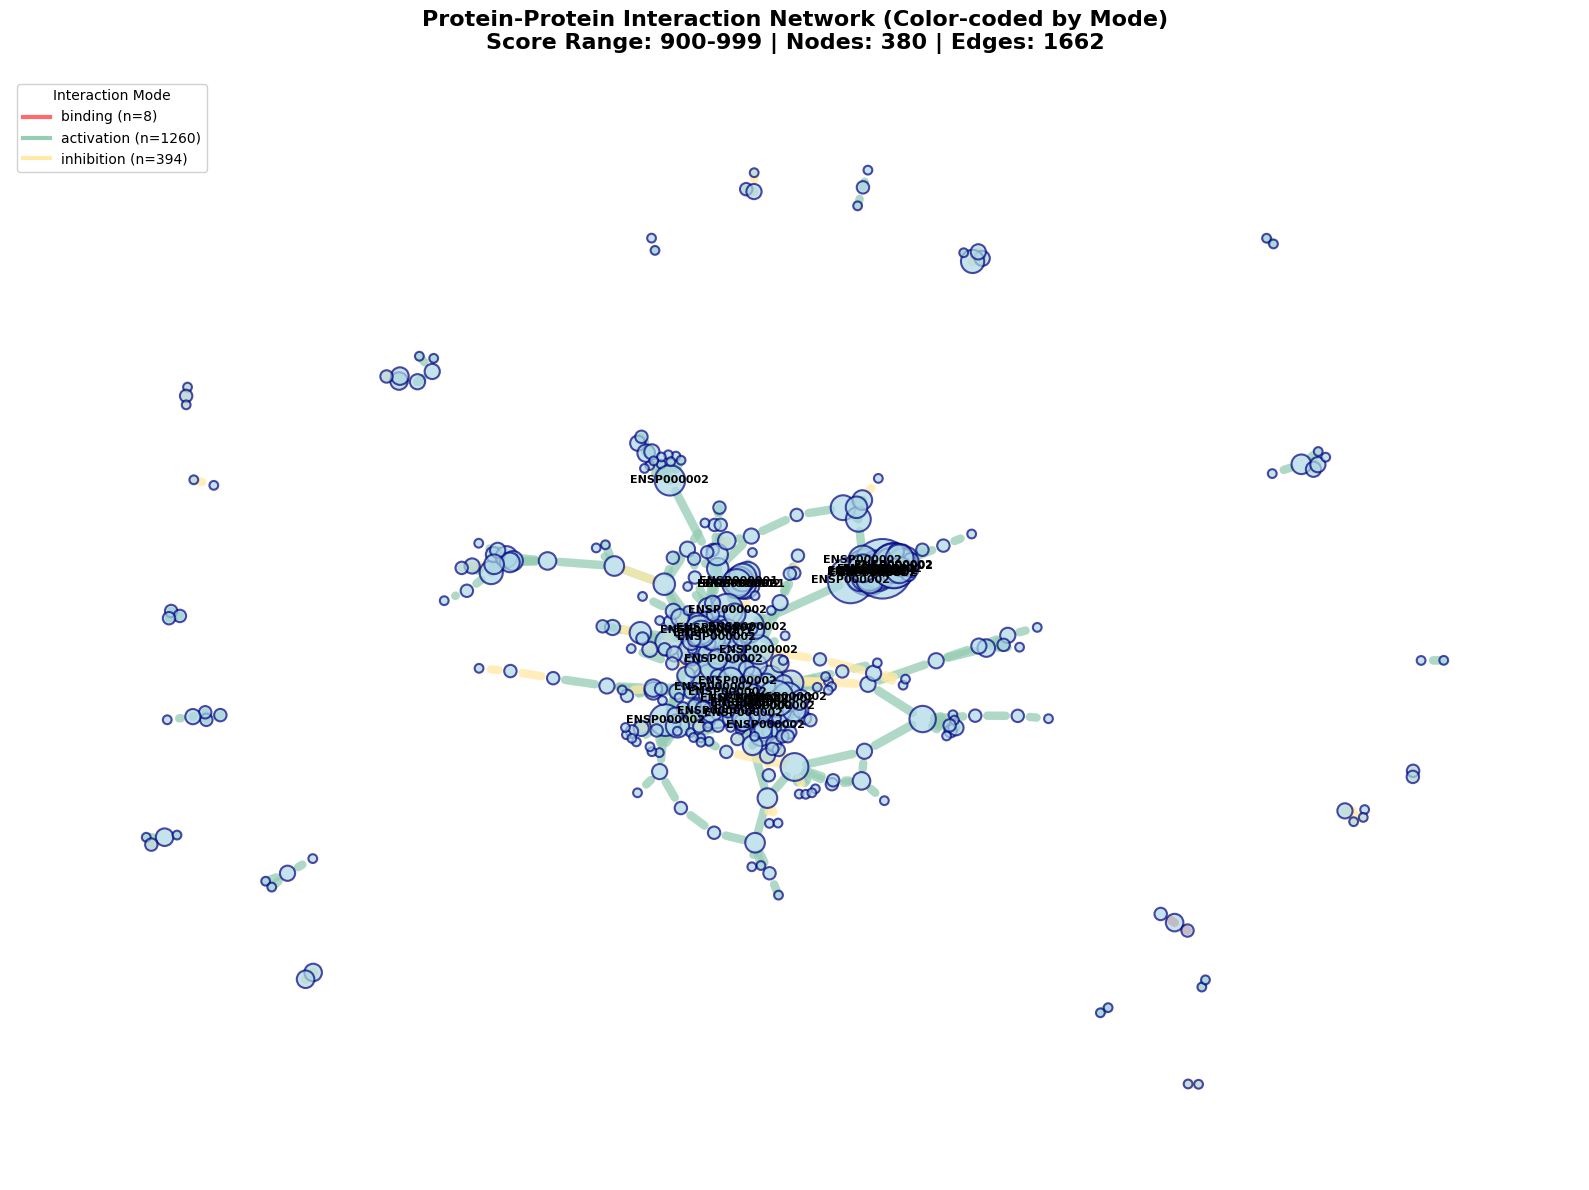


Network Statistics:
  Average degree: 8.75
  Network density: 0.0231
  Number of connected components: 22

Edge distribution by mode:
  activation: 1260 (75.8%)
  inhibition: 394 (23.7%)
  binding: 8 (0.5%)


In [67]:
# Network Visualization
def visualize_ppi_network(df, min_score=0, max_score=None, max_nodes=500, figsize=(16, 12)):
    """
    Visualize protein-protein interaction network with edges colored by mode.
    
    Parameters:
    -----------
    df : pd.DataFrame
        The PPI dataframe with columns: item_id_a, item_id_b, mode, score
    min_score : int
        Minimum score threshold for edges (default: 0)
    max_score : int or None
        Maximum score threshold for edges (default: None, no upper limit)
    max_nodes : int
        Maximum number of nodes to display (for performance)
    figsize : tuple
        Figure size (default: (16, 12))
    
    Returns:
    --------
    G : networkx.MultiGraph
        The constructed network graph (MultiGraph to handle multiple edge types)
    """
    
    # Filter by score range
    if max_score is None:
        filtered_df = df[df['score'] >= min_score]
        score_range_str = f"≥ {min_score}"
    else:
        filtered_df = df[(df['score'] >= min_score) & (df['score'] <= max_score)]
        score_range_str = f"{min_score}-{max_score}"
    
    if len(filtered_df) == 0:
        print(f"No interactions found with score {score_range_str}")
        return None
    
    print(f"Found {len(filtered_df)} interactions with score {score_range_str}")
    
    # Create MultiGraph to allow multiple edges between same nodes
    G = nx.MultiGraph()
    
    # Define color map for modes
    mode_colors = {
        'binding': '#FF6B6B',      # Red
        'reaction': '#4ECDC4',     # Teal
        'catalysis': '#45B7D1',    # Blue
        'activation': '#96CEB4',   # Green
        'inhibition': '#FFEAA7',   # Yellow
        'ptmod': '#DFE6E9',        # Light gray
        'expression': '#A29BFE'    # Purple
    }
    
    # Add edges with mode and score attributes
    for _, row in filtered_df.iterrows():
        G.add_edge(row['item_id_a'], row['item_id_b'], 
                  mode=row['mode'], 
                  weight=row['score'])
    
    print(f"Network has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")
    
    # Limit nodes if too large
    if G.number_of_nodes() > max_nodes:
        print(f"Network too large. Showing top {max_nodes} nodes by degree...")
        # Get top nodes by degree
        top_nodes = sorted(G.degree(), key=lambda x: x[1], reverse=True)[:max_nodes]
        top_node_ids = [node for node, degree in top_nodes]
        G = G.subgraph(top_node_ids).copy()
        
        # Re-filter the dataframe to match the subgraph
        node_set = set(G.nodes())
        filtered_df = filtered_df[
            (filtered_df['item_id_a'].isin(node_set)) & 
            (filtered_df['item_id_b'].isin(node_set))
        ]
    
    # Calculate node sizes based on degree
    degrees = dict(G.degree())
    node_sizes = [degrees[node] * 20 for node in G.nodes()]
    
    # Create layout
    pos = nx.spring_layout(G, k=0.5, iterations=50, seed=42)
    
    # Plot
    fig, ax = plt.subplots(figsize=figsize)
    
    # Draw nodes
    nx.draw_networkx_nodes(G, pos, 
                          node_size=node_sizes,
                          node_color='lightblue',
                          alpha=0.7,
                          edgecolors='navy',
                          linewidths=1.5,
                          ax=ax)
    
    # Draw edges by mode with different colors
    for mode, color in mode_colors.items():
        # Get edges of this mode
        mode_edges = [(u, v, k) for u, v, k, d in G.edges(keys=True, data=True) 
                     if d['mode'] == mode]
        
        if mode_edges:
            # Get weights for edge widths
            weights = [G[u][v][k]['weight'] for u, v, k in mode_edges]
            edge_widths = [w / 150 for w in weights]  # Scale for visibility
            
            # Draw edges for this mode
            nx.draw_networkx_edges(G, pos,
                                  edgelist=[(u, v) for u, v, k in mode_edges],
                                  width=edge_widths,
                                  alpha=0.5,
                                  edge_color=color,
                                  ax=ax)
    
    # Draw labels for high-degree nodes only
    if len(degrees) > 0:
        high_degree_threshold = np.percentile(list(degrees.values()), 90)
        high_degree_nodes = {node: node.split('.')[-1][:10] 
                            for node, deg in degrees.items() if deg >= high_degree_threshold}
        
        nx.draw_networkx_labels(G, pos,
                               labels=high_degree_nodes,
                               font_size=8,
                               font_weight='bold',
                               ax=ax)
    
    # Create legend - using matplotlib.lines.Line2D
    mode_counts = filtered_df['mode'].value_counts()
    legend_elements = [
        plt.Line2D([0], [0], color=mode_colors[mode], lw=3, 
                   label=f'{mode} (n={mode_counts.get(mode, 0)})')
        for mode in mode_colors.keys() if mode in mode_counts.index
    ]
    
    ax.legend(handles=legend_elements, loc='upper left', fontsize=10, 
             framealpha=0.9, title='Interaction Mode')
    
    plt.title(f'Protein-Protein Interaction Network (Color-coded by Mode)\nScore Range: {score_range_str} | Nodes: {G.number_of_nodes()} | Edges: {G.number_of_edges()}',
             fontsize=16, fontweight='bold', pad=20)
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    # Print network statistics
    print(f"\nNetwork Statistics:")
    print(f"  Average degree: {np.mean(list(degrees.values())):.2f}")
    print(f"  Network density: {nx.density(G):.4f}")
    print(f"  Number of connected components: {nx.number_connected_components(G)}")
    
    print(f"\nEdge distribution by mode:")
    for mode, count in mode_counts.items():
        percentage = (count / len(filtered_df)) * 100
        print(f"  {mode}: {count} ({percentage:.1f}%)")
    
    return G

# Example usage:
ppi_df = data['protein.actions.SHS27k.STRING.pro2']

# Visualize network with different score thresholds
G = visualize_ppi_network(ppi_df, min_score=900, max_score=999)